# Model Selection

### Bayes Rule and Evidence

$m$: model, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{y}$: dataset, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\Theta_m$: parameters of model $m$

$$P(\Theta_m | \mathbf{y}, m) = \frac{P(\mathbf{y}|\Theta_m, m) P(\Theta_m | m)}{P(\mathbf{y} | m)}$$

The Evidence (Marginal Likelihood), $Z$, is deined to be the denominator in the above equation. It is explicitly shown below.

$$Z = P(\mathbf{y} | m) = \frac{P(\Theta_m, \mathbf{y} | m)}{P(\Theta_m | \mathbf{y}, m)}$$

### The Laplace Approximation

Let the posterior be approximated by a $d$-dimensional multivariate normal distribution. $m$, $\mathbf{y}$ and $\hat{\Theta}_m$ will denote the model, data set, MAP estimate respectively.

$$P(\Theta_m | \mathbf{y}, m) \approx (2\pi)^{-\frac{d}{2}} |\Sigma|^{-\frac{1}{2}} \exp\big[ -\frac{1}{2} (\Theta_m - \hat{\Theta}_m)^T \Sigma^{-1} (\Theta_m - \hat{\Theta}_m) \big] $$

$$P(\mathbf{y} | m) = \frac{P(\Theta_m, \mathbf{y} | m)}{P(\Theta_m | \mathbf{y}, m)}$$

$$\implies \ln P(\mathbf{y} | m) \approx \ln P(\hat{\Theta}_m | m) + \ln P(\mathbf{y} | \hat{\Theta}_m, m) + 
   \frac{d}{2}\ln 2\pi + \frac{1}{2}\ln |\Sigma|$$

### Bayesian Information Criterion (BIC)

The BIC is a further approximation to the Laplace approximation in the limit of lots of data when the posterior is dominated by the likelihood. With $N$ being the number of data points the BIC is defined as follows.

$$\ln P(\mathbf{y} | m) \approx \text{BIC} = \ln P(\mathbf{y} | \hat{\Theta}_m, m) - \frac{d}{2} \ln N$$

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import corner
import h5py
import json

In [136]:
import pandas as pd

In [3]:
from scipy.stats import norm

In [4]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

In [5]:
def read_samples(file_path):
    samples = {}
    with h5py.File(file_path, 'r') as fp:
        for key in fp.keys():
            samples[key] = fp[(key)][()]
    return samples

In [6]:
def BIC(N, samples=None, logL=None, d=None):
    """
    N: float
        The number of data points.
    samples: dict
        Dictionary of samples from numpyro run.
    logL: float
        Log Likelihood @ the MLE OR Log Likelihood + Log Prior @ the MAP.
    d: float
        Number of fitted parameters
    """
    
    if (logL is not None) and (d is not None):
        return logL - d*np.log(N)/2.
    
    elif samples:
        all_samples = np.concatenate([samples[key] for key in samples 
                                       if key not in ['countries', 'potential_energy']], axis=1)
        logPL =  np.max(-samples['potential_energy'])
        d = all_samples.shape[1]
        return logPL - d*np.log(N)/2.
    
    else:
        print('Need either samples or logL and d.')

In [7]:
def AIC(samples=None, logL=None, d=None):
    """
    N: float
        The number of data points.
    samples: dict
        Dictionary of samples from numpyro run.
    logL: float
        Log Likelihood @ the MLE OR Log Likelihood + Log Prior @ the MAP.
    d: float
        Number of fitted parameters
    """
    
    if (logL is not None) and (d is not None):
        return logL - d
    
    elif samples:
        all_samples = np.concatenate([samples[key] for key in samples 
                                       if key not in ['countries', 'potential_energy']], axis=1)
        logPL =  np.max(-samples['potential_energy'])
        d = all_samples.shape[1]
        return logPL - d
    
    else:
        print('Need either samples or logL and d.')

In [8]:
def log_evidence(samples):
    log_p_plus_log_l = np.max(-samples['potential_energy'])
    all_samples = np.concatenate([samples[key] for key in samples 
                                   if key not in ['countries', 'potential_energy']], axis=1)
    cov = np.cov(all_samples.T)
    d = len(cov)
    D, Q = np.linalg.eigh(cov)
    log_post = d*np.log(2*np.pi)/2. + np.sum(np.log(D))/2.
    return log_p_plus_log_l + log_post

In [9]:
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'r') as fp:
    t0 = np.mean(fp['t0'][()], axis=0)
countries = np.loadtxt('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_countries.txt', 
                        delimiter='|', dtype=str)[:,0]

t0_dict = dict(zip(countries, t0.astype(np.int32)))

with h5py.File('../data/nb_samples/4.1.1.8.4_INCL_BLOOD_MultiVariate_Regression_samples.h5', 'r') as fp:
    all_countries = [c.decode() for c in fp['countries'][()]]
    
N_data = np.sum([t0_dict[c] for c in all_countries])

In [10]:
N_data

613

In [10]:
# sample_files = ['../data/nb_samples/4.1.1.11_BCG_Regression_samples.h5',
#                 '../data/nb_samples/4.1.1.2.2_TEMP_Regression_samples.h5',
#                 '../data/nb_samples/4.1.1.3.3_HUMID_Regression_samples.h5', 
#                 '../data/nb_samples/4.1.1.4.2_TESTS_Regression_samples.h5',
#                 '../data/nb_samples/4.1.1.5.2_POSITIVES_Regression_samples.h5', 
#                 '../data/nb_samples/4.1.1.7.2_BLOOD_Regression_samples.h5', 
#                 '../data/nb_samples/4.1.1.8.4_INCL_BLOOD_MultiVariate_Regression_samples.h5', 
#                 '../data/nb_samples/4.1.1.9.2_EXCL_TESTS_MultiVariate_Regression_samples.h5']
samples_tight = ['../data/nb_samples/4.1.1.2.3_TIGHTPRIOR_TEMP_Regression_samples.h5',
                 '../data/nb_samples/4.1.1.8.5_TIGHTPRIOR_INCL_BLOOD_MultiVariate_Regression_samples.h5'
                ]

In [77]:
# temp_tight = read_samples(samples_tight[0])
# incl_test_tight = read_samples(samples_tight[1])
incl_test_tight = read_samples('../data/nb_samples/4.1.1.11.0_EXCL_BLOOD_TIGHT_MultiVariate_Regression_samples.h5')

In [12]:
round(AIC(temp_tight), 1), round(BIC(N_data, temp_tight), 1), round(log_evidence(temp_tight), 1)

(-1772.9, -1960.7, -1848.7)

In [82]:
# bcg, temp, hum, tests, pos, blood = [read_samples(sample_files[f]) for f in samples_files]
bcg = read_samples('../data/nb_samples/4.1.1.11_BCG_Regression_samples.h5')
temp = read_samples('../data/nb_samples/4.1.1.2.2_TEMP_Regression_samples.h5')
hum = read_samples('../data/nb_samples/4.1.1.3.3_HUMID_Regression_samples.h5')
test = read_samples('../data/nb_samples/4.1.1.4.2_TESTS_Regression_samples.h5')
pos = read_samples('../data/nb_samples/4.1.1.5.2_POSITIVES_Regression_samples.h5')
blood = read_samples('../data/nb_samples/4.1.1.7.2_BLOOD_Regression_samples.h5')
# incl_test = read_samples('../data/nb_samples/4.1.1.11.0_INCL_UV_MultiVariate_Regression_samples.h5')
incl_test_blood = read_samples('../data/nb_samples/4.1.1.11.0_INCL_UV_MultiVariate_Regression_samples.h5')
incl_test = read_samples('../data/nb_samples/4.1.1.11.0_EXCL_BLOOD_MultiVariate_Regression_samples.h5')
# excl_test = read_samples('../data/nb_samples/4.1.1.9.2_EXCL_TESTS_MultiVariate_Regression_samples.h5')
# excl_test = read_samples('../data/nb_samples/4.1.1.12.0_INCL_UV_EXCL_TEST_MultiVariate_Regression_samples.h5')
excl_test = read_samples('../data/nb_samples/4.1.1.12.0_EXCL_BLOOD_EXCL_TEST_MultiVariate_Regression_samples.h5')
uv = read_samples('../data/nb_samples/4.1.1.3.5_UVINDEX_MEAN_Regression_samples.h5')
none = read_samples('../data/nb_samples/4.1.1.3.6_NOPARAM_Regression_samples.h5')
none['potential_energy'] = none['potential_energy'][::2]
hum['potential_energy'] = hum['potential_energy'][::2]
uv['potential_energy'] = uv['potential_energy'][::2]

In [14]:
ABE = []
for m in [none, bcg, temp, hum, uv, test, pos, blood, excl_test, incl_test]:
    abe = [AIC(m), BIC(N_data, m), log_evidence(m), float(np.max(-m['potential_energy']))]
    ABE.append([round(x, 1) for x in abe])

In [15]:
models = ['No Factors', 'BCG Vaccine', 'Temperature', 'Relative Humidity', 'UV Index', 
          'Tests/1k', 'Positive Rate', 'A+ Blood Type', 'All excl. Tests', 'All incl. Tests']
# print('Model & AIC & BIC & \Delta logZ \\\ ')
for i, abe in enumerate(ABE):
    print(f'{models[i]} & {round(abe[0]-ABE[-4][0],1)} & {round(abe[1]-ABE[-4][1],1)} & {round(abe[2]-ABE[-4][2],1)} & {round(abe[3]-ABE[-4][3],1)} \\\ ')

No Factors & -8.0 & -5.8 & -1.8 & -9.0 \\ 
BCG Vaccine & -7.3 & -7.3 & -6.9 & -7.3 \\ 
Temperature & -6.8 & -6.8 & -5.6 & -6.8 \\ 
Relative Humidity & -2.7 & -2.7 & -1.7 & -2.7 \\ 
UV Index & -6.3 & -6.3 & -3.2 & -6.3 \\ 
Tests/1k & -7.6 & -7.6 & -6.7 & -7.6 \\ 
Positive Rate & 0.0 & 0.0 & 0.0 & 0.0 \\ 
A+ Blood Type & -5.3 & -5.3 & -3.7 & -5.3 \\ 
All excl. Tests & -53.3 & -62.1 & -69.6 & -49.3 \\ 
All incl. Tests & -48.1 & -61.4 & -76.1 & -42.1 \\ 


# Parameter Estimates

In [23]:
def describe(x):
    return np.mean(x, axis=0), np.std(x, axis=0)

In [24]:
mn, std = describe(none['GR_ind'])
mn = 100*(mn - 1)
std = 100*std

In [25]:
mn, std

(array([30.515373, 34.7481  , 41.105713, 35.067104, 16.896952, 19.021666,
        11.624742, 14.998674,  5.423999, 26.985847, 13.193953, 30.287027,
        13.61773 , 24.48312 , 28.976715, 19.166588, 19.339907, 11.305534,
        23.219622, 20.607544, 15.987051, 19.975555, 20.40943 , 16.243767,
        13.309741, 26.134418, 28.08913 , 18.460321, 10.603213, 14.557433,
        10.157955, 20.134008, 15.49089 , 19.295513, 27.017094, 17.32452 ,
        20.343506, 14.286613, 26.952053, 25.313545], dtype=float32),
 array([0.9973182 , 1.5110282 , 2.8509543 , 0.75409716, 2.3734686 ,
        1.5598966 , 1.7276893 , 1.5534952 , 2.5391335 , 2.7578003 ,
        1.51922   , 2.6180112 , 1.2959919 , 1.0815227 , 0.9401884 ,
        1.2753936 , 0.889518  , 1.6374979 , 1.5458658 , 2.7393584 ,
        1.138815  , 1.7455943 , 0.37049577, 1.0788879 , 1.8352544 ,
        1.5067962 , 1.3660084 , 2.5529544 , 2.1337037 , 2.1978724 ,
        1.5392778 , 0.6525816 , 2.119427  , 2.219958  , 1.307521  ,
        1.6

In [26]:
mn1, std1 = [100*x for x in describe(incl_test['W'])]

In [27]:
W = np.concatenate([x['alpha'][:10000] for x in [bcg, temp, hum, test, pos, blood, uv]], axis=1)
mn2, std2 = [100*x for x in describe(W)]

In [19]:
N_theta = len(mn1)
dec = 3
# params = ['\Theta_{BCG}', '\Theta_{Temp}', '\Theta_{RH}', '\Theta_{Tests/1k}', 
#           '\Theta_{Pos.Rate}', '\Theta_{A+}', '\Theta_{UV}']
params = ['BCG Vaccine Coverage', 'Temperature', 'Relative Humidity', 'Tests/1k', 
          'Positive Rate', 'A+ Blood Type', 'UV Index']
print('Parameter & Multivariate Model Incl. Tests & Univariate Model Incl. Tests')
for i in range(N_theta):
    print(f'{params[i].ljust(20)} & {str(round(mn1[i],dec))} $\pm$ {str(round(std1[i],dec))} ({str(round(mn1[i]/std1[i], 2))}$\sigma$) & {str(round(mn2[i],dec))} $\pm$ {str(round(std2[i],dec))} ({str(round(mn2[i]/std2[i], 2))}$\sigma$) \\\ ')

Parameter & Multivariate Model Incl. Tests & Univariate Model Incl. Tests
BCG Vaccine Coverage & 0.006 $\pm$ 0.039 (0.15$\sigma$) & 0.002 $\pm$ 0.04 (0.04$\sigma$) \\ 
Temperature          & -0.341 $\pm$ 0.156 (-2.19$\sigma$) & -0.193 $\pm$ 0.132 (-1.45$\sigma$) \\ 
Relative Humidity    & -0.129 $\pm$ 0.077 (-1.67$\sigma$) & -0.093 $\pm$ 0.092 (-1.01$\sigma$) \\ 
Tests/1k             & -0.092 $\pm$ 0.116 (-0.79$\sigma$) & -0.139 $\pm$ 0.11 (-1.26$\sigma$) \\ 
Positive Rate        & 0.276 $\pm$ 0.083 (3.31$\sigma$) & 0.272 $\pm$ 0.079 (3.43$\sigma$) \\ 
A+ Blood Type        & -0.122 $\pm$ 0.202 (-0.6$\sigma$) & 0.087 $\pm$ 0.19 (0.46$\sigma$) \\ 
UV Index             & 0.067 $\pm$ 0.953 (0.07$\sigma$) & -0.472 $\pm$ 0.888 (-0.53$\sigma$) \\ 


In [227]:
def mk_param_names(factors):
    param_names = ['$\mu_{D_0}$', '$\sigma_{D_0}$']
    param_names += ['$\mathbf{D_0}_{\\text{'+str(c)+'}}$' for c in all_countries]
    param_names += ['$\mu_{G_0}$', '$\sigma_{G_0}$']
    param_names += ['$\mathbf{G_0}_{\\text{'+str(c)+'}}$' for c in all_countries]
    param_names += ['$\mathbf{\Theta}_{'+x+'}$' for x in ['BCG', 'Temp', 'RH', 'Tests/1k', 'Pos.Rate', 'A+', 'UV'] if x in factors]
    
    return param_names

In [96]:
def transform_params(samples):
    new_samples = samples.copy()
    new_samples['GR_grp_mean'] = 100*(samples['GR_grp_mean']-1)
    new_samples['GR_grp_sigma'] = 100*samples['GR_grp_sigma']
    new_samples['GR_ind'] = 100*(samples['GR_ind']-1)
    if 'W' in samples.keys():
        new_samples['W'] = 100*samples['W']
    elif 'alpha' in samples.keys():
        new_samples['alpha'] = 100*samples['alpha']
    
    all_chains = np.concatenate([new_samples[key] for key in new_samples.keys() if new_samples[key].ndim>1], 
                                axis=1)
    return all_chains

In [125]:
transform_params(samples[i]).shape

(10000, 85)

In [183]:
test123 = mk_param_names(factors[9])

In [184]:
df = pd.DataFrame(data=transform_params(samples[9]), columns=mk_param_names(factors[9])).T
df['Name'] = df.index

In [185]:
df.sort_values('Name').values[:,:-1].astype(np.float64).shape

(90, 20000)

In [186]:
df

,0,1,2,3,4,5,6,7,8,9,...,19991,19992,19993,19994,19995,19996,19997,19998,19999,Name
$\mu_{D_0}$,5.846701,6.633373,6.134942,5.873414,5.835620,5.893895,5.600464,5.859139,5.384778,5.487310,...,6.622923,6.622923,6.622923,6.622923,6.622923,6.622923,6.622923,6.622923,6.622923,$\mu_{D_0}$
$\sigma_{D_0}$,2.185570,2.458095,2.334163,2.044407,2.395659,2.000462,1.927406,2.154674,1.823551,2.069633,...,1.006466,1.006466,1.006466,1.006466,1.006466,1.006466,1.006466,1.006466,1.006466,$\sigma_{D_0}$
$\mathbf{D_0}_{Germany}$,5.444887,4.228590,5.857927,4.341156,5.732465,4.303861,5.937741,4.526901,5.804467,5.662656,...,15.466037,15.466037,15.466037,15.466037,15.466037,15.466037,15.466037,15.466037,15.466037,$\mathbf{D_0}_{Germany}$
$\mathbf{D_0}_{Netherlands}$,2.726073,2.272676,2.782032,2.518961,3.099444,2.319597,2.678353,3.044987,2.243575,2.086533,...,11.669387,11.669387,11.669387,11.669387,11.669387,11.669387,11.669387,11.669387,11.669387,$\mathbf{D_0}_{Netherlands}$
$\mathbf{D_0}_{United Kingdom}$,4.826780,5.130453,5.185329,4.179547,4.501308,4.347030,5.274745,4.109773,5.646443,5.660584,...,12.405394,12.405394,12.405394,12.405394,12.405394,12.405394,12.405394,12.405394,12.405394,$\mathbf{D_0}_{United Kingdom}$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
$\mathbf{W}_{Temp}$,-0.551610,-0.307772,-0.335981,-0.352491,-0.361812,-0.299280,-0.364938,-0.315302,-0.242381,-0.226364,...,-0.184653,-0.184653,-0.184653,-0.184653,-0.184653,-0.184653,-0.184653,-0.184653,-0.184653,$\mathbf{W}_{Temp}$
$\mathbf{W}_{RH}$,-0.246608,-0.131237,-0.101004,-0.040063,-0.163144,-0.218853,-0.026462,0.002170,-0.107933,-0.111006,...,-0.976843,-0.976843,-0.976843,-0.976843,-0.976843,-0.976843,-0.976843,-0.976843,-0.976843,$\mathbf{W}_{RH}$
$\mathbf{W}_{Tests/1k}$,-0.259012,-0.283160,-0.215546,-0.076547,-0.188717,-0.197746,0.244828,0.175933,0.051132,-0.006651,...,-0.445091,-0.445091,-0.445091,-0.445091,-0.445091,-0.445091,-0.445091,-0.445091,-0.445091,$\mathbf{W}_{Tests/1k}$
$\mathbf{W}_{Pos.Rate}$,0.120158,0.157019,0.184607,0.241405,0.243259,0.133586,0.390608,0.254349,0.385924,0.335925,...,-0.147999,-0.147999,-0.147999,-0.147999,-0.147999,-0.147999,-0.147999,-0.147999,-0.147999,$\mathbf{W}_{Pos.Rate}$


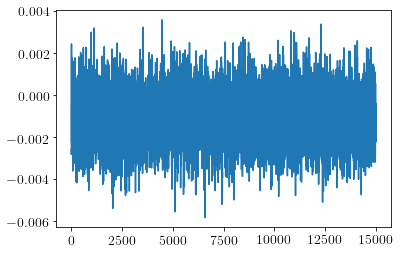

In [195]:
plt.plot(incl_test['W'][:15000,3])

In [200]:
df.sort_values('Name')

,0,1,2,3,4,5,6,7,8,9,...,19991,19992,19993,19994,19995,19996,19997,19998,19999,Name
$\mathbf{D_0}_{Argentina}$,4.630954,4.391440,4.850997,4.781734,5.057369,4.880876,5.584181,3.931610,4.773807,5.385810,...,16.480516,16.480516,16.480516,16.480516,16.480516,16.480516,16.480516,16.480516,16.480516,$\mathbf{D_0}_{Argentina}$
$\mathbf{D_0}_{Australia / New South Wales}$,1.955342,4.059299,1.998183,4.459348,2.478969,3.952597,3.597908,2.535698,3.524144,2.756974,...,11.188925,11.188925,11.188925,11.188925,11.188925,11.188925,11.188925,11.188925,11.188925,$\mathbf{D_0}_{Australia / New South Wales}$
$\mathbf{D_0}_{Austria}$,6.803895,6.228366,6.219071,7.054000,5.623911,6.047413,6.155578,7.173717,6.264854,7.435267,...,16.924057,16.924057,16.924057,16.924057,16.924057,16.924057,16.924057,16.924057,16.924057,$\mathbf{D_0}_{Austria}$
$\mathbf{D_0}_{Canada / Alberta}$,3.653883,3.155354,2.895750,5.842835,3.623158,4.694567,3.011627,3.049001,4.398658,3.717516,...,15.272679,15.272679,15.272679,15.272679,15.272679,15.272679,15.272679,15.272679,15.272679,$\mathbf{D_0}_{Canada / Alberta}$
$\mathbf{D_0}_{Canada / British Columbia}$,3.167174,3.105394,2.799931,3.708385,3.197013,3.313184,3.183222,4.170683,2.526431,2.326558,...,14.621544,14.621544,14.621544,14.621544,14.621544,14.621544,14.621544,14.621544,14.621544,$\mathbf{D_0}_{Canada / British Columbia}$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
$\mathbf{W}_{UV}$,-0.131366,1.461335,0.436889,0.077398,-0.346875,-1.886187,1.445459,0.222104,-0.891375,-1.451126,...,-0.631527,-0.631527,-0.631527,-0.631527,-0.631527,-0.631527,-0.631527,-0.631527,-0.631527,$\mathbf{W}_{UV}$
$\mu_{D_0}$,5.846701,6.633373,6.134942,5.873414,5.835620,5.893895,5.600464,5.859139,5.384778,5.487310,...,6.622923,6.622923,6.622923,6.622923,6.622923,6.622923,6.622923,6.622923,6.622923,$\mu_{D_0}$
$\mu_{G_0}$,42.543484,31.307793,26.770615,16.954363,29.608250,35.631729,11.151016,12.078630,21.254528,24.199867,...,22.904909,22.904909,22.904909,22.904909,22.904909,22.904909,22.904909,22.904909,22.904909,$\mu_{G_0}$
$\sigma_{D_0}$,2.185570,2.458095,2.334163,2.044407,2.395659,2.000462,1.927406,2.154674,1.823551,2.069633,...,1.006466,1.006466,1.006466,1.006466,1.006466,1.006466,1.006466,1.006466,1.006466,$\sigma_{D_0}$


In [228]:
c = ChainConsumer()
models = ['No Factors', 'BCG Vaccine', 'Temperature', 
          'Relative Humidity', 'Tests / 1k', 'Positive Rate', 
          'A+ Blood Type', 'UV Index', 'Excl. Tests', 'Incl. Tests']
factors = [[''], ['BCG'], ['Temp'], ['RH'], ['Tests/1k'], 
           ['Pos.Rate'], ['A+'], ['UV'],
           ['BCG', 'Temp', 'RH', 'UV'], 
           ['BCG', 'Temp', 'RH', 'Tests/1k', 'Pos.Rate', 'UV']]
samples = [none, bcg, temp, hum, test, pos, blood, uv, excl_test, incl_test]

for i, model in enumerate(models):
    
    df = pd.DataFrame(data=transform_params(samples[i]), columns=mk_param_names(factors[i])).T
    df['Name'] = df.index
    if i==9:
        c.add_chain(chain=df.sort_values('Name').values[:,:15000].astype(np.float64).T, 
                    parameters=list(df.sort_values('Name').Name), name=model)
    else:
        c.add_chain(chain=df.sort_values('Name').values[:,:-1].astype(np.float64).T, 
                    parameters=list(df.sort_values('Name').Name), name=model)

table = c.analysis.get_latex_table(caption="Parameter Estimates for each model.", 
                                   label="tab:example",
                                   transpose=True)

print(table)

\begin{table}
    \centering
    \caption{Parameter Estimates for each model.}
    \label{tab:example}
    \begin{tabular}{ccccccccccc}
        \hline
		Parameter & No Factors & BCG Vaccine & Temperature & Relative Humidity & Tests / 1k & Positive Rate & A+ Blood Type & UV Index & Excl. Tests & Incl. Tests \\ 
		\hline
		$\mathbf{D_0}_{\text{Argentina}}$ & $4.02^{+0.70}_{-0.82}$ & $3.78^{+0.95}_{-0.56}$ & $4.03^{+0.79}_{-0.73}$ & $3.85^{+0.83}_{-0.66}$ & $4.02^{+0.67}_{-0.82}$ & $3.99^{+0.77}_{-0.76}$ & $3.96\pm 0.77$ & $3.89^{+0.85}_{-0.69}$ & $8.86^{+1.09}_{-0.91}$ & $4.57^{+0.48}_{-0.42}$ \\ 
		$\mathbf{D_0}_{\text{Australia / New South Wales}}$ & $4.39^{+1.00}_{-0.78}$ & $4.27^{+1.13}_{-0.67}$ & $4.41^{+1.04}_{-0.79}$ & $4.43^{+0.99}_{-0.81}$ & $4.61^{+0.78}_{-1.06}$ & $4.34^{+1.03}_{-0.76}$ & $4.44^{+0.95}_{-0.87}$ & $4.34^{+1.02}_{-0.79}$ & $4.94^{+0.67}_{-0.60}$ & $3.09^{+0.67}_{-0.54}$ \\ 
		$\mathbf{D_0}_{\text{Austria}}$ & $5.21^{+0.73}_{-0.89}$ & $5.12\pm 0.80$ & $5.14^{+0.7

# Model Comparison

In [121]:
uni = [bcg, temp, hum, test, pos, uv]
models = ['BCG Vaccine', 'Temperature', 
          'Relative Humidity', 'Tests / 1k', 
          'Positive Rate', 'UV Index']

In [123]:
for i in range(len(uni)):
    name = models[i]
    
    mean1 = str(round(100*np.mean(uni[i]['alpha']), 2))
    std1 = str(round(100*np.std(uni[i]['alpha']), 2))
    
    mean2 = str(round(100*np.mean(incl_test['W'][:15000,i]), 2))
    std2 = str(round(100*np.std(incl_test['W'][:15000,i]), 2))
    
    print(f'{name} & {mean2} $\pm$ {std2} & {mean1} $\pm$ {std1} \\\ ')


BCG Vaccine & 0.01 $\pm$ 0.04 & 0.0 $\pm$ 0.04 \\ 
Temperature & -0.29 $\pm$ 0.14 & -0.19 $\pm$ 0.13 \\ 
Relative Humidity & -0.1 $\pm$ 0.08 & -0.09 $\pm$ 0.09 \\ 
Tests / 1k & -0.11 $\pm$ 0.12 & -0.14 $\pm$ 0.11 \\ 
Positive Rate & 0.25 $\pm$ 0.08 & 0.27 $\pm$ 0.08 \\ 
UV Index & -0.01 $\pm$ 0.95 & -0.47 $\pm$ 0.89 \\ 


In [106]:
c = ChainConsumer()
models = ['No Factors', 'BCG Vaccine', 'Temperature', 
          'Relative Humidity', 'Tests / 1k', 'Positive Rate', 
          'A+ Blood Type', 'UV Index', 'Excl. Tests', 'Incl.Tests']
factors = [[''], ['BCG'], ['Temp'], ['RH'], ['Tests/1k'], 
           ['Pos.Rate'], ['A+'], ['UV'],
           ['BCG', 'Temp', 'RH', 'UV'], 
           ['BCG', 'Temp', 'RH', 'Tests/1k', 'Pos.Rate', 'UV']]
samples = [none, bcg, temp, hum, test, pos, blood, uv, excl_test, incl_test]

for i, model in enumerate(models):
    if i==9:
        param_names = mk_param_names(factors[i])
        c.add_chain(chain=transform_params(samples[i])[:15000], parameters=param_names, 
                    name=model, posterior=-samples[i]['potential_energy'][:15000], 
                    num_eff_data_points=int(N_data), num_free_params=len(param_names))
    else:
        param_names = mk_param_names(factors[i])
        c.add_chain(chain=transform_params(samples[i]), parameters=param_names, 
                    name=model, posterior=-samples[i]['potential_energy'], 
                    num_eff_data_points=int(N_data), num_free_params=len(param_names))

table = c.comparison.comparison_table(caption="Model comparisons!", descending=False)

print(table)

\begin{table}
    \centering
    \caption{Model comparisons!}
    \label{tab:model_comp}
    \begin{tabular}{cccc}
        \hline
	Model & AIC & BIC  & DIC  \\ 
	\hline
	Positive Rate  &    0.0    &    0.0    &    0.0   \\ 
	Relative Humidity  &    5.5    &    5.5    &   31.8   \\ 
	A+ Blood Type  &   10.7    &   10.7    &   23.4   \\ 
	No Factors  &   15.3    &   11.6    &   22.9   \\ 
	Temperature  &   13.7    &   13.7    &   24.0   \\ 
	BCG Vaccine  &   14.7    &   14.7    &   13.6   \\ 
	UV Index  &   14.7    &   14.7    &   30.5   \\ 
	Tests / 1k  &   15.2    &   15.2    &   28.6   \\ 
	Incl.Tests  &  114.5    &  132.9    &  113.2   \\ 
	Excl. Tests  &  125.9    &  137.0    &  127.4   \\ 
	\hline
    \end{tabular}
\end{table}


In [310]:
c = ChainConsumer()
models = ['No Factors', 'BCG Vaccine', 'Temperature', 
          'Relative Humidity', 'Tests / 1k', 'Positive Rate', 
          'A+ Blood Type', 'UV Index', 'Excl. Tests', 'Incl.Tests']
factors = [[''], ['BCG'], ['Temp'], ['RH'], ['Tests/1k'], 
           ['Pos.Rate'], ['A+'], ['UV'],
           ['BCG', 'Temp', 'RH', 'A+', 'UV'], 
           ['BCG', 'Temp', 'RH', 'Tests/1k', 'Pos.Rate', 'A+', 'UV']]
samples = [none, bcg, temp, hum, test, pos, blood, uv, excl_test, incl_test]

for i, model in enumerate(models):
    param_names = mk_param_names(factors[i])
    c.add_chain(chain=transform_params(samples[i]), parameters=param_names, 
                name=model, posterior=-samples[i]['potential_energy'], 
                num_eff_data_points=int(N_data), num_free_params=len(param_names))

table = c.comparison.comparison_table(caption="Model comparisons!")

print(table)

\begin{table}
    \centering
    \caption{Model comparisons!}
    \label{tab:model_comp}
    \begin{tabular}{cccc}
        \hline
	Model & AIC & BIC  & DIC  \\ 
	\hline
	Excl. Tests  &  109.5    &  124.3    &  124.6   \\ 
	Incl.Tests  &  100.7    &  122.8    &  116.2   \\ 
	Tests / 1k  &   15.2    &   15.2    &   28.6   \\ 
	UV Index  &   14.7    &   14.7    &   30.5   \\ 
	BCG Vaccine  &   14.7    &   14.7    &   13.6   \\ 
	Temperature  &   13.7    &   13.7    &   24.0   \\ 
	No Factors  &   15.3    &   11.6    &   22.9   \\ 
	A+ Blood Type  &   10.7    &   10.7    &   23.4   \\ 
	Relative Humidity  &    5.5    &    5.5    &   31.8   \\ 
	Positive Rate  &    0.0    &    0.0    &    0.0   \\ 
	\hline
    \end{tabular}
\end{table}


In [291]:
n = 10000
d1 = norm.rvs(size=n)
p1 = norm.logpdf(d1)
p2 = norm.logpdf(d1, scale=1.1)

c = ChainConsumer()
c.add_chain(d1, posterior=p1, name="Model A", num_eff_data_points=n, num_free_params=)
c.add_chain(d1, posterior=p2, name="Model B", num_eff_data_points=n, num_free_params=5)
c.add_chain(d1, posterior=p2, name="Model C", num_eff_data_points=n, num_free_params=4)
c.add_chain(d1, posterior=p1, name="Model D", num_eff_data_points=n, num_free_params=14)
table = c.comparison.comparison_table(caption="Model comparisons!")
print(table)

\begin{table}
    \centering
    \caption{Model comparisons!}
    \label{tab:model_comp}
    \begin{tabular}{cccc}
        \hline
	Model & AIC & BIC  & DIC  \\ 
	\hline
	Model D  &   20.0    &   92.1    &    0.1   \\ 
	Model B  &    2.2    &    9.4    &    0.0   \\ 
	Model C  &    0.2    &    0.2    &    0.0   \\ 
	Model A  &    0.0    &    0.0    &    0.1   \\ 
	\hline
    \end{tabular}
\end{table}


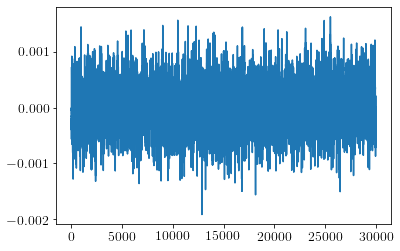

In [116]:
plt.plot(bcg['alpha'])

In [293]:
p1.shape

(10000,)

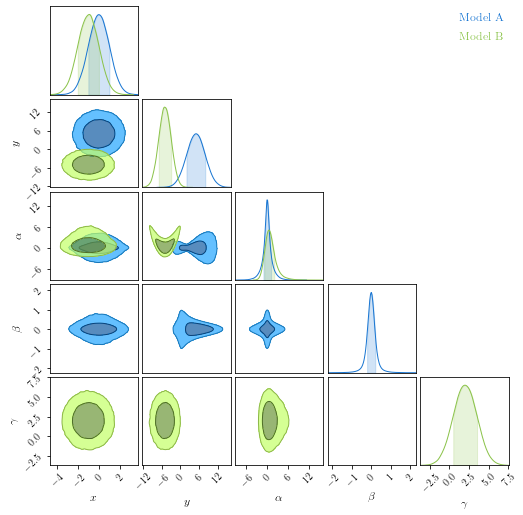

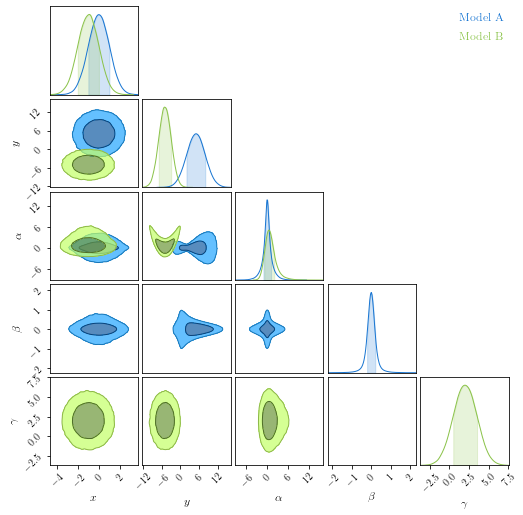

In [60]:
ndim, nsamples = 4, 200000
np.random.seed(0)

data = np.random.randn(nsamples, ndim)
data[:, 2] += data[:, 1] * data[:, 2]
data[:, 1] = data[:, 1] * 3 + 5
data[:, 3] /= (np.abs(data[:, 1]) + 1)

data2 = np.random.randn(nsamples, ndim)
data2[:, 0] -= 1
data2[:, 2] += data2[:, 1]**2
data2[:, 1] = data2[:, 1] * 2 - 5
data2[:, 3] = data2[:, 3] * 1.5 + 2

# If you pass in parameter labels and only one chain, you can also get parameter bounds
c = ChainConsumer()
c.add_chain(data, parameters=["$x$", "$y$", r"$\alpha$", r"$\beta$"], name="Model A")
c.add_chain(data2, parameters=["$x$", "$y$", r"$\alpha$", r"$\gamma$"], name="Model B")
c.plotter.plot()
# table = c.analysis.get_latex_table(caption="Results for the tested models", label="tab:example")
# print(table)

# Plots 

In [58]:
single_samples = np.concatenate([bcg['alpha'][:10000],]+[x['alpha'] for x in [temp, hum, test, pos, uv]], 
                                axis=1)

In [59]:
single_samples.shape

(10000, 6)

In [221]:
plt.rcParams['font.size'] = 18

In [89]:
blood['alpha'].shape

(10000, 1)

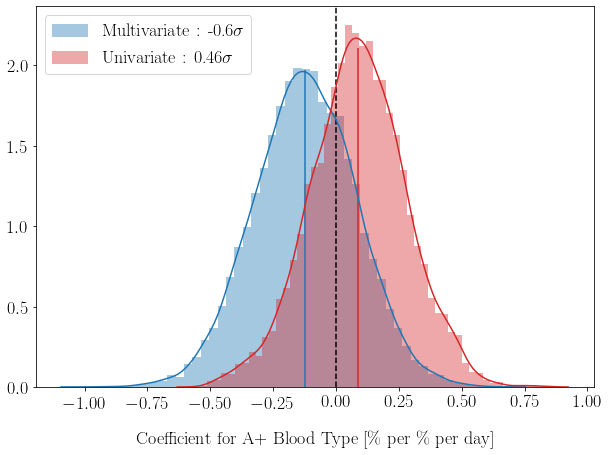

In [222]:
fig, ax = plt.subplots(1,1, figsize=(10, 7))
# a = ax.flatten()
param_name = ['A+ Blood Type']
param_units = ['\%']
for i in range(1):
    
    significance = str(round(np.mean(incl_test_blood['W'][:,-2])/np.std(incl_test_blood['W'][:,-2]), 2))
    sns.distplot(100*incl_test_blood['W'][:,-2], bins=50, 
#                  fit=norm, 
                 ax = ax,
                 fit_kws={'color':'blue'}, color='tab:blue', 
                 label=f'Multivariate : {significance}$\sigma$')
    significance = str(round(np.mean(blood['alpha'][:,i])/np.std(blood['alpha'][:,i]), 2))
    sns.distplot(100*blood['alpha'][:,i], bins=50, 
#                  fit=norm, 
                 ax = ax,
                 fit_kws={'color':'red'}, color='tab:red', 
                 label=f'Univariate : {significance}$\sigma$')
    
    ax.vlines(100*np.mean(incl_test_blood['W'][:,-2]), 0, 
                norm.pdf(100*np.mean(incl_test_blood['W'][:,-2]), *norm.fit(100*incl_test_blood['W'][:,-2])),
                color='tab:blue')
    ax.vlines(100*np.mean(blood['alpha'][:,i]), 0, 
                norm.pdf(100*np.mean(blood['alpha'][:,i]), *norm.fit(100*blood['alpha'][:,i])),
                color='tab:red')
    
    ax.set_xlabel(f'Coefficient for {param_name[i]} [\% per {param_units[i]} per day]', 
                    labelpad=20)
    lims = ax.get_ylim()
    ax.vlines(0, lims[0], lims[1], colors='k', linestyle='dashed')
    ax.set_ylim(*lims)
#     lims = ax.get_xlim()
#     lim_range = np.diff(lims)
#     mid = lims[0]+lim_range/2
#     ax.set_xlim(mid-0.6*lim_range, mid+0.6*lim_range)
#     ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax.legend(loc='upper left')
    
plt.subplots_adjust(hspace=0.3)
plt.savefig('../plots/6._Blood_Overplot.png', dpi=200)

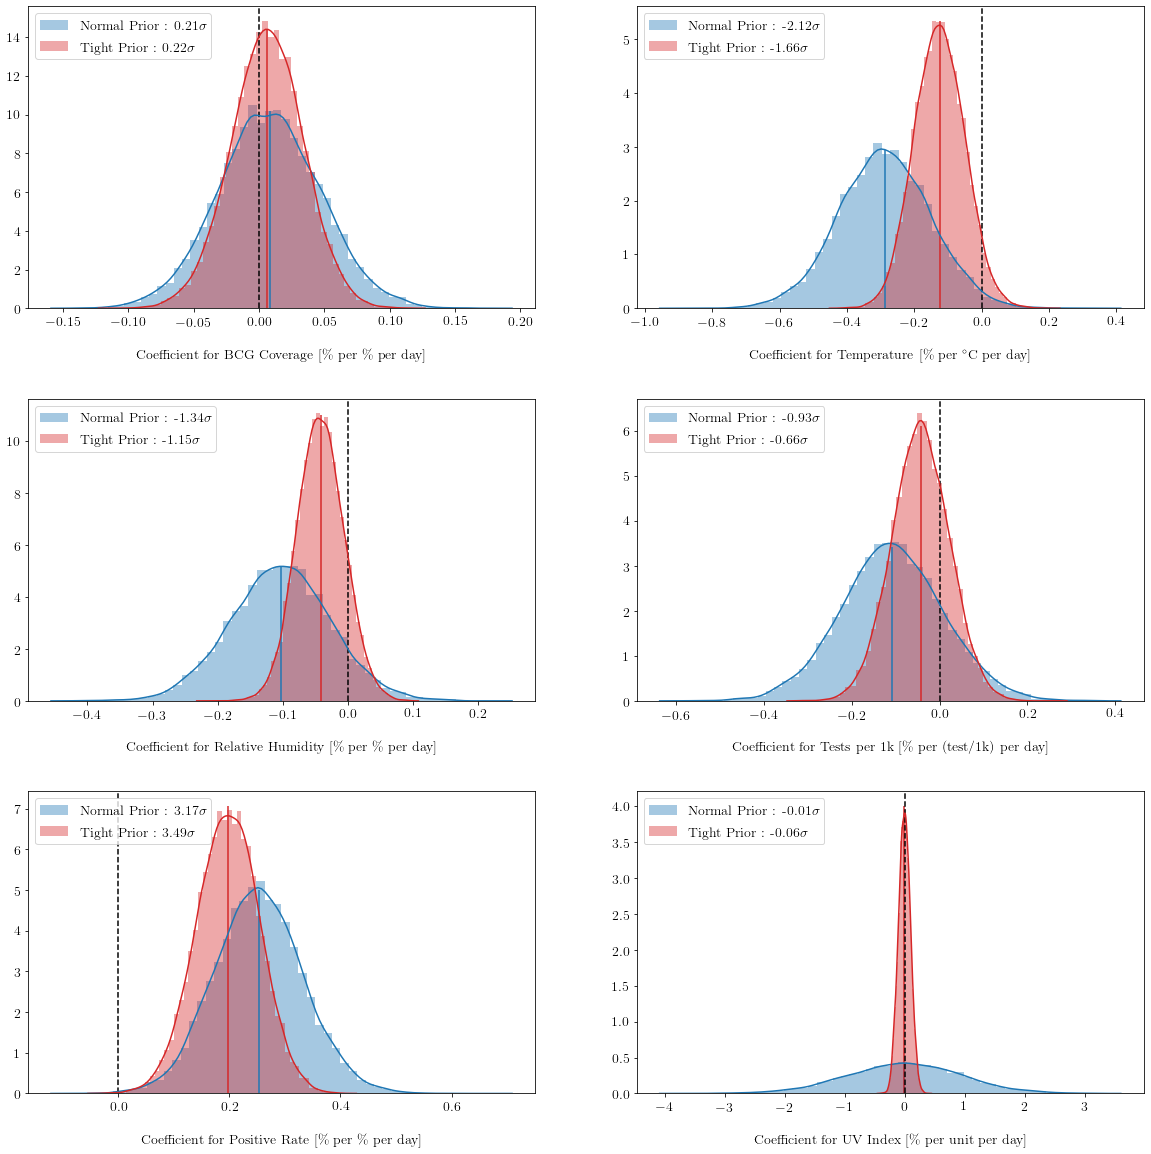

In [81]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 'Positive Rate', 'UV Index']
param_units = ['\%', r'$^\circ$C', '\%', '(test/1k)', '\%', 'unit']
for i in range(6):
    
    significance = str(round(np.mean(incl_test['W'][:15000,i])/np.std(incl_test['W'][:15000,i]), 2))
    sns.distplot(100*incl_test['W'][:15000,i], bins=50, 
#                  fit=norm, 
                 ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', 
                 label=f'Normal Prior : {significance}$\sigma$')
    significance = str(round(np.mean(incl_test_tight['W'][:,i])/np.std(incl_test_tight['W'][:,i]), 2))
    sns.distplot(100*incl_test_tight['W'][:,i], bins=50, 
#                  fit=norm, 
                 ax = a[i],
                 fit_kws={'color':'red'}, color='tab:red', 
                 label=f'Tight Prior : {significance}$\sigma$')
    
    a[i].vlines(100*np.mean(incl_test['W'][:15000,i]), 0, 
                norm.pdf(100*np.mean(incl_test['W'][:15000,i]), *norm.fit(100*incl_test['W'][:15000,i])),
                color='tab:blue')
    a[i].vlines(100*np.mean(incl_test_tight['W'][:,i]), 0, 
                norm.pdf(100*np.mean(incl_test_tight['W'][:,i]), *norm.fit(100*incl_test_tight['W'][:,i])),
                color='tab:red')
    
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [\% per {param_units[i]} per day]', 
                    labelpad=20)
    lims = a[i].get_ylim()
    a[i].vlines(0, lims[0], lims[1], colors='k', linestyle='dashed')
    a[i].set_ylim(*lims)
#     lims = a[i].get_xlim()
#     lim_range = np.diff(lims)
#     mid = lims[0]+lim_range/2
#     a[i].set_xlim(mid-0.6*lim_range, mid+0.6*lim_range)
#     a[i].ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    a[i].legend(loc='upper left')
    
plt.subplots_adjust(hspace=0.3)
plt.savefig('../plots/6._Marginals_with_Overplot_TIGHT_excl_blood.png', dpi=200)

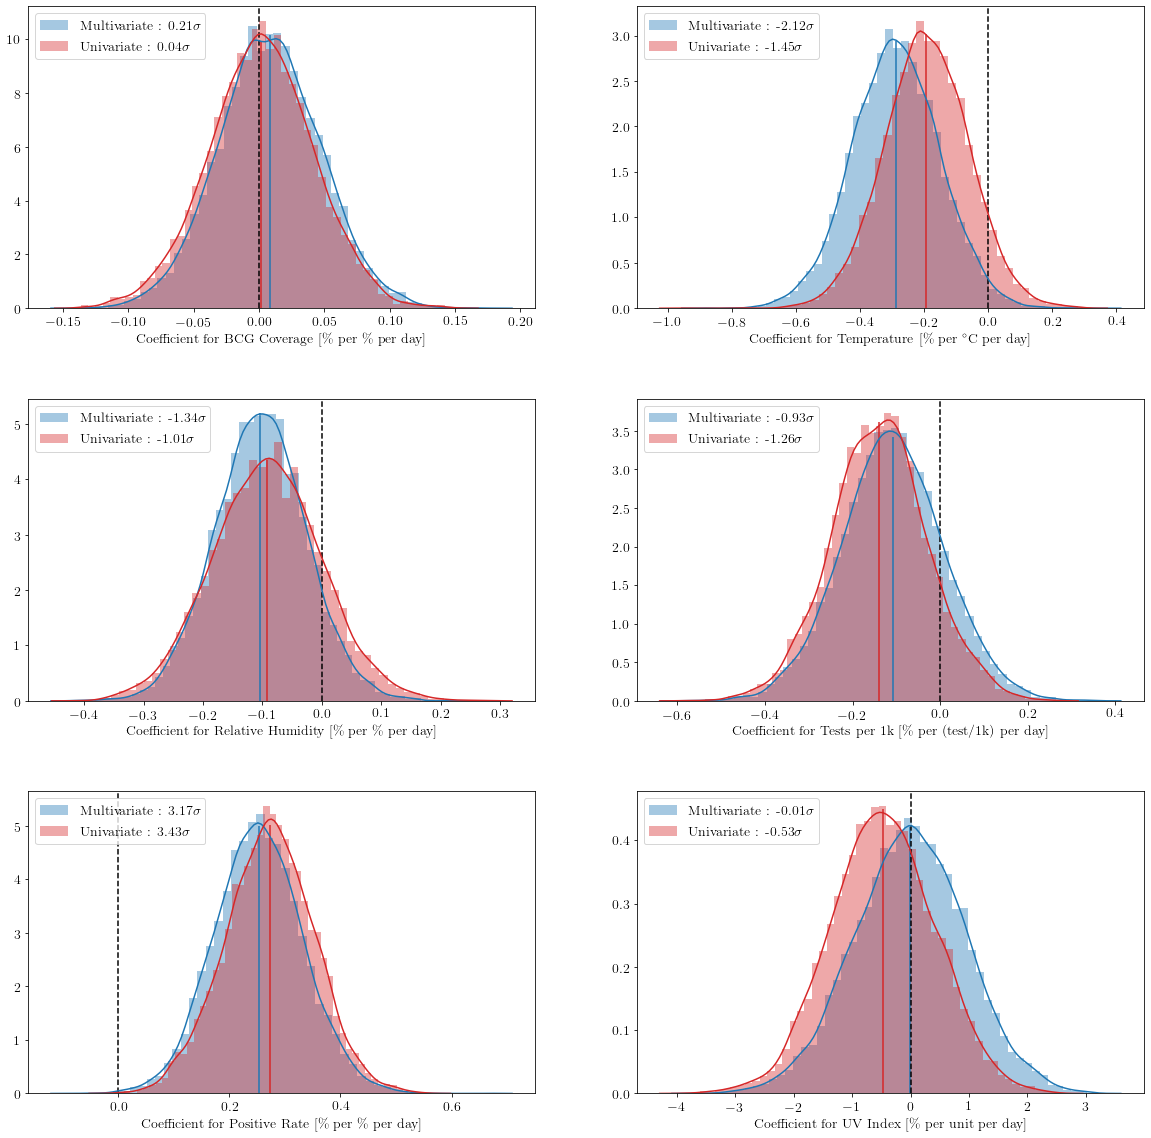

In [68]:
single_samples = np.concatenate([bcg['alpha'][:10000],]+[x['alpha'] for x in [temp, hum, test, pos, uv]], 
                                axis=1)

fig, ax = plt.subplots(3, 2, figsize=(20, 20))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 
              'Positive Rate', 'UV Index']
param_units = ['\%', r'$^\circ$C', '\%', '(test/1k)', '\%', 'unit']
for i in range(6):
    
    significance = str(round(np.mean(incl_test['W'][:15000,i])/np.std(incl_test['W'][:15000,i]), 2))
    sns.distplot(100*incl_test['W'][:15000,i], bins=50, 
#                  fit=norm, 
                 ax = a[i],
                 fit_kws={'color':'tab:blue'}, color='tab:blue', 
                 label=f'Multivariate : {significance}$\sigma$')
    
    significance = str(round(np.mean(single_samples[:,i])/np.std(single_samples[:,i]), 2))
    sns.distplot(100*single_samples[:,i], bins=50, 
#                  fit=norm, 
                 ax = a[i],
                 fit_kws={'color':'tab:red'}, color='tab:red', 
                 label=f'Univariate : {significance}$\sigma$')
    
    a[i].vlines(100*np.mean(incl_test['W'][:15000,i]), 0, 
                norm.pdf(100*np.mean(incl_test['W'][:15000,i]), *norm.fit(100*incl_test['W'][:15000,i])),
                color='tab:blue')
    a[i].vlines(100*np.mean(single_samples[:,i]), 0, 
                norm.pdf(100*np.mean(single_samples[:,i]), *norm.fit(100*single_samples[:,i])),
                color='tab:red')
    
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [\% per {param_units[i]} per day]', 
#                     labelpad=20
                   )
    lims = a[i].get_ylim()
    a[i].vlines(0, lims[0], lims[1], colors='k', linestyle='dashed')
    a[i].set_ylim(*lims)
#     lims = a[i].get_xlim()
#     lim_range = np.diff(lims)
#     mid = lims[0]+lim_range/2
#     a[i].set_xlim(mid-0.6*lim_range, mid+0.5*lim_range)
#     a[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='x')
    a[i].legend(loc='upper left')
    
# a[-1].set_axis_off()
plt.subplots_adjust(hspace=0.3)
plt.savefig('../plots/6._Marginals_with_Overplot_excl_blood.png', dpi=200)

In [ ]:
single_samples = np.concatenate([bcg['alpha'][:10000],]+[x['alpha'] for x in [temp, hum, test, pos, blood, uv]], 
                                axis=1)

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 
              'Positive Rate', 'A+ Blood Type', 'UV Index']
param_units = ['\%', r'$^\circ$C', '\%', '(test/1k)', '\%', '\%', 'unit']
for i in range(7):
    
    significance = str(round(np.mean(incl_test['W'][:,i])/np.std(incl_test['W'][:,i]), 2))
    sns.distplot(100*incl_test['W'][:,i], bins=50, 
#                  fit=norm, 
                 ax = a[i],
                 fit_kws={'color':'tab:blue'}, color='tab:blue', 
                 label=f'Multivariate : {significance}$\sigma$')
    
    significance = str(round(np.mean(single_samples[:,i])/np.std(single_samples[:,i]), 2))
    sns.distplot(100*single_samples[:,i], bins=50, 
#                  fit=norm, 
                 ax = a[i],
                 fit_kws={'color':'tab:red'}, color='tab:red', 
                 label=f'Univariate : {significance}$\sigma$')
    
    a[i].vlines(100*np.mean(incl_test['W'][:,i]), 0, 
                norm.pdf(100*np.mean(incl_test['W'][:,i]), *norm.fit(100*incl_test['W'][:,i])),
                color='tab:blue')
    a[i].vlines(100*np.mean(single_samples[:,i]), 0, 
                norm.pdf(100*np.mean(single_samples[:,i]), *norm.fit(100*single_samples[:,i])),
                color='tab:red')
    
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [\% per {param_units[i]} per day]', 
#                     labelpad=20
                   )
    lims = a[i].get_ylim()
    a[i].vlines(0, lims[0], lims[1], colors='k', linestyle='dashed')
    a[i].set_ylim(*lims)
#     lims = a[i].get_xlim()
#     lim_range = np.diff(lims)
#     mid = lims[0]+lim_range/2
#     a[i].set_xlim(mid-0.6*lim_range, mid+0.5*lim_range)
#     a[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='x')
    a[i].legend(loc='upper left')
    
a[-1].set_axis_off()
plt.subplots_adjust(hspace=0.3)
# plt.savefig('../plots/6._Marginals_with_Overplot.png', dpi=200)

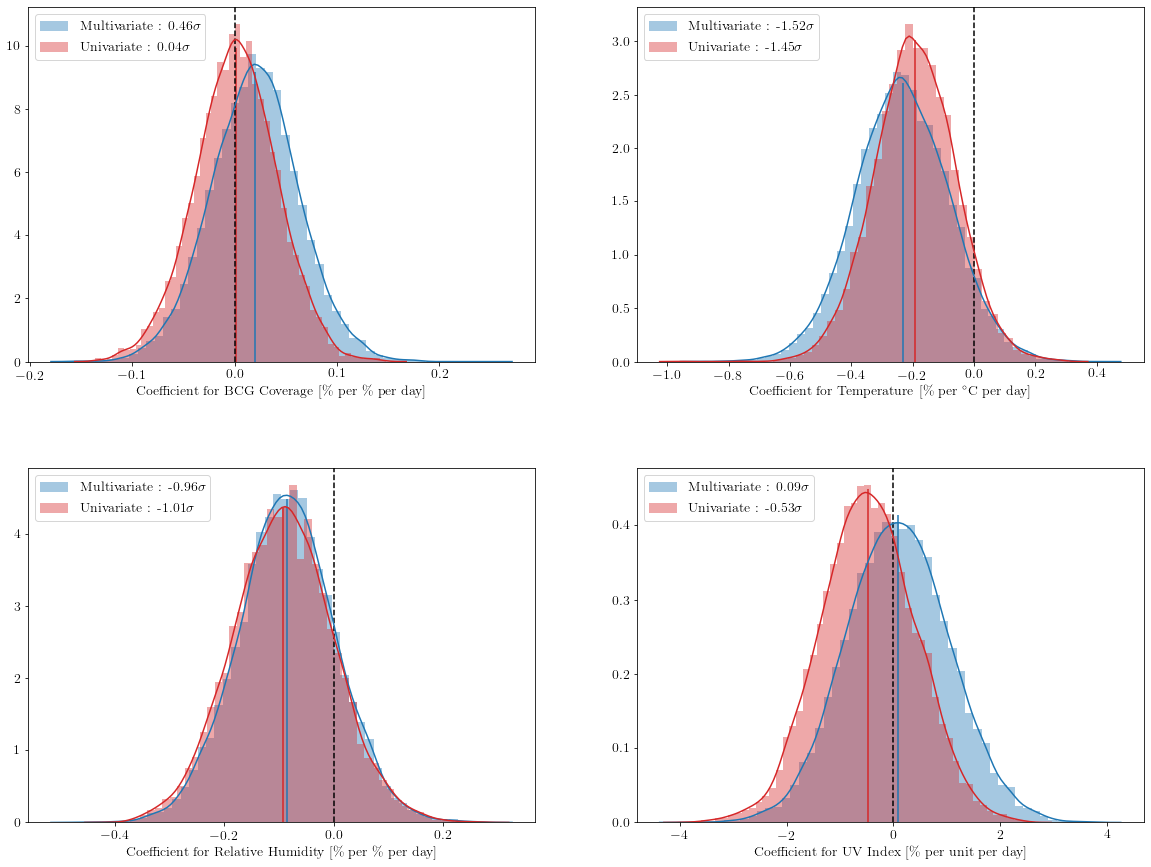

In [67]:
single_samples = np.concatenate([bcg['alpha'][:10000],]+[x['alpha'] for x in [temp, hum, uv]], 
                                axis=1)
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'UV Index']
param_units = ['\%', r'$^\circ$C', '\%', 'unit']

for i in range(4):

    significance = str(round(np.mean(excl_test['W'][:,i])/np.std(excl_test['W'][:,i]), 2))
    sns.distplot(100*excl_test['W'][:,i], bins=50, 
#                  fit=norm, 
                 ax = a[i],
                 fit_kws={'color':'tab:blue'}, color='tab:blue', 
                 label=f'Multivariate : {significance}$\sigma$')
    
    a[i].vlines(100*np.mean(excl_test['W'][:,i]), 0, 
                norm.pdf(100*np.mean(excl_test['W'][:,i]), *norm.fit(100*excl_test['W'][:,i])),
                color='tab:blue')
        
    significance = str(round(np.mean(single_samples[:,i])/np.std(single_samples[:,i]), 2))
    sns.distplot(100*single_samples[:,i], bins=50, 
#                  fit=norm, 
                 ax = a[i],
                 fit_kws={'color':'tab:red'}, color='tab:red', 
                 label=f'Univariate : {significance}$\sigma$')
    a[i].vlines(100*np.mean(single_samples[:,i]), 0, 
                norm.pdf(100*np.mean(single_samples[:,i]), *norm.fit(100*single_samples[:,i])),
                color='tab:red') 
    
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [\% per {param_units[i]} per day]', 
#                     labelpad=20
                   )
    lims = a[i].get_ylim()
    a[i].vlines(0, lims[0], lims[1], colors='k', linestyle='dashed')
    a[i].set_ylim(*lims)
#     lims = a[i].get_xlim()
#     lim_range = np.diff(lims)
#     mid = lims[0]+lim_range/2
#     a[i].set_xlim(mid-0.6*lim_range, mid+0.5*lim_range)
#     a[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='x')
    a[i].legend(loc='upper left')

# a[-1].set_axis_off()
plt.subplots_adjust(hspace=0.3)
plt.savefig('../plots/6._Marginals_with_Overplot_excl_test_ex_blood.png', dpi=200)

In [74]:
plt.rcParams['font.size'] = 12

In [ ]:
plt.rcParams['font.size'] = 14

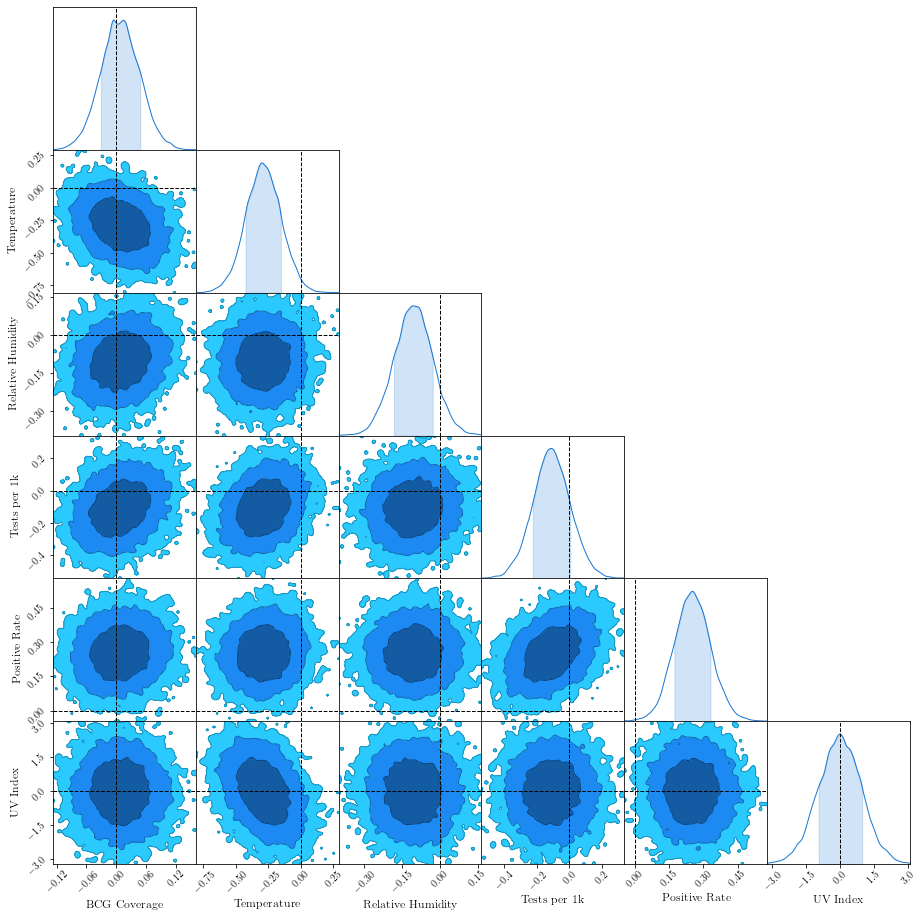

In [75]:
params = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 
          'Positive Rate', 'UV Index']
# params = [r'$\Theta_1$', r'$\Theta_2$', r'$\Theta_3$', r'$\Theta_4$', r'$\Theta_5$']
c = ChainConsumer()
c.add_chain(100*incl_test['W'][:15000,:], parameters=params,)
# c.add_chain(100*single_samples[:,:3], parameters=["$x$", "$y$", r"$\beta$"])

c.configure(
# # #             linestyles=["-", "--"], 
            sigmas=[0, 1, 2, 3],
            
# #             legend_kwargs={"loc": "lower left", "fontsize": 20},
# # #             legend_color_text=False, 
# # #             legend_location=(0, 0)
            )

fig = c.plotter.plot(filename='../plots/9_Incl_Test_Corner_3sigma_excl_blood.png', truth=np.zeros(7), )
fig.set_size_inches(5 + fig.get_size_inches()) 
# fig.

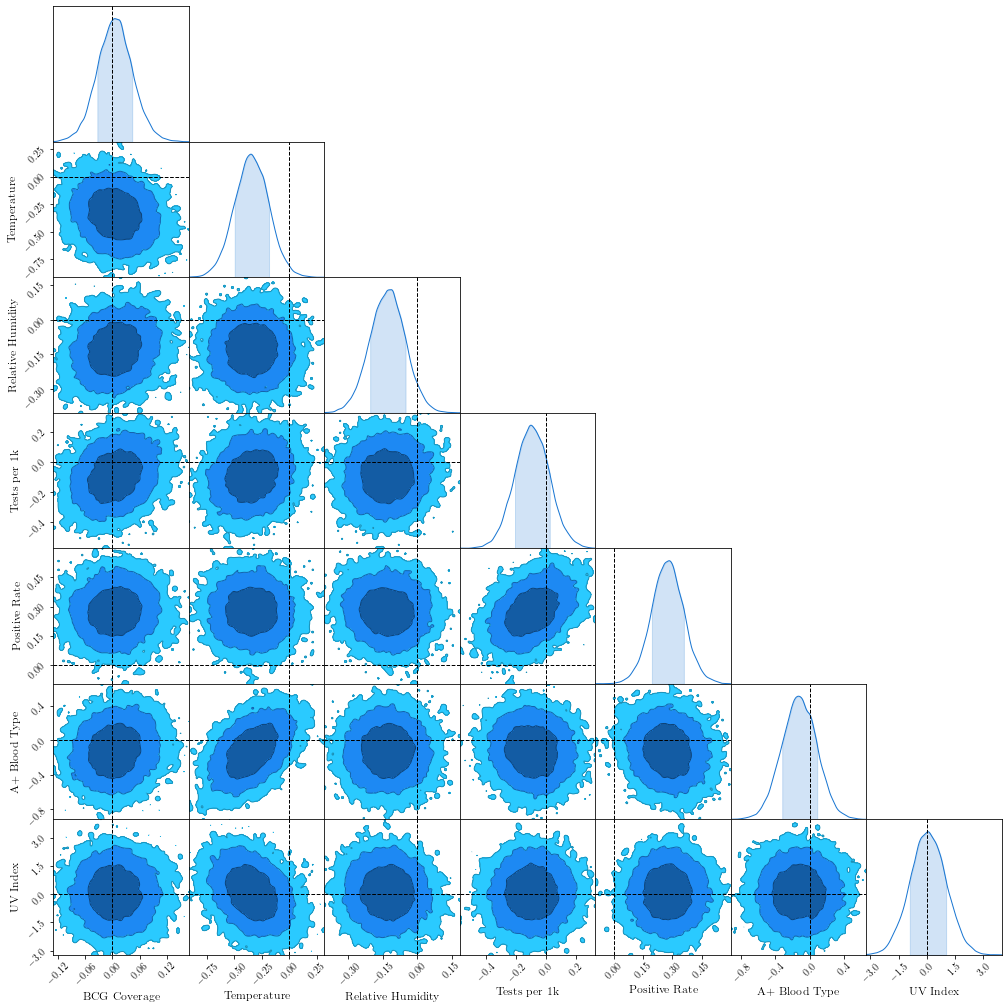

In [100]:
params = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 
          'Positive Rate', 'A+ Blood Type', 'UV Index']
# params = [r'$\Theta_1$', r'$\Theta_2$', r'$\Theta_3$', r'$\Theta_4$', r'$\Theta_5$']
c = ChainConsumer()
c.add_chain(100*incl_test['W'], parameters=params)
# c.add_chain(100*single_samples[:,:3], parameters=["$x$", "$y$", r"$\beta$"])

c.configure(
# # #             linestyles=["-", "--"], 
            sigmas=[0, 1, 2, 3],
            
# #             legend_kwargs={"loc": "lower left", "fontsize": 20},
# # #             legend_color_text=False, 
# # #             legend_location=(0, 0)
            )

fig = c.plotter.plot(filename='../plots/9_Incl_Test_Corner_3sigma.png', truth=np.zeros(7))
fig.set_size_inches(5 + fig.get_size_inches()) 
# fig.

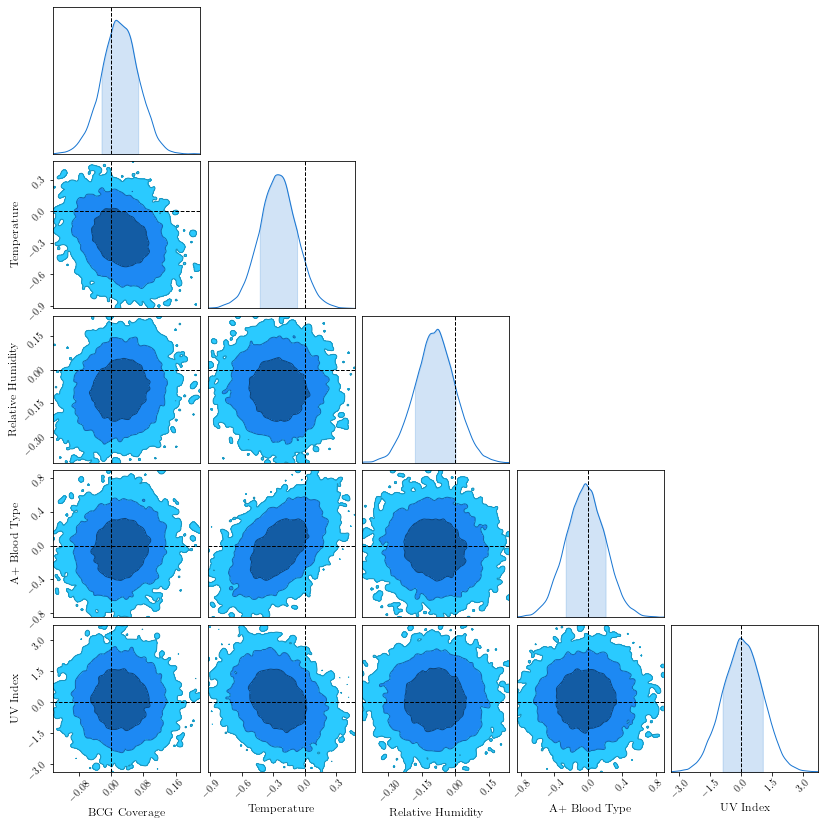

In [101]:
params = ['BCG Coverage', 'Temperature', 'Relative Humidity', 
          'A+ Blood Type', 'UV Index']
# params = [r'$\Theta_1$', r'$\Theta_2$', r'$\Theta_3$', r'$\Theta_4$', r'$\Theta_5$']
c = ChainConsumer()
c.add_chain(100*excl_test['W'], parameters=params)
# c.add_chain(100*single_samples[:,:3], parameters=["$x$", "$y$", r"$\beta$"])

c.configure(
# # #             linestyles=["-", "--"], 
            sigmas=[0, 1, 2, 3],
            
# #             legend_kwargs={"loc": "lower left", "fontsize": 20},
# # #             legend_color_text=False, 
# # #             legend_location=(0, 0)
            )

fig = c.plotter.plot(filename='../plots/9_Excl_Test_Corner_3sigma.png', truth=np.zeros(5))
fig.set_size_inches(5 + fig.get_size_inches()) 
# fig.

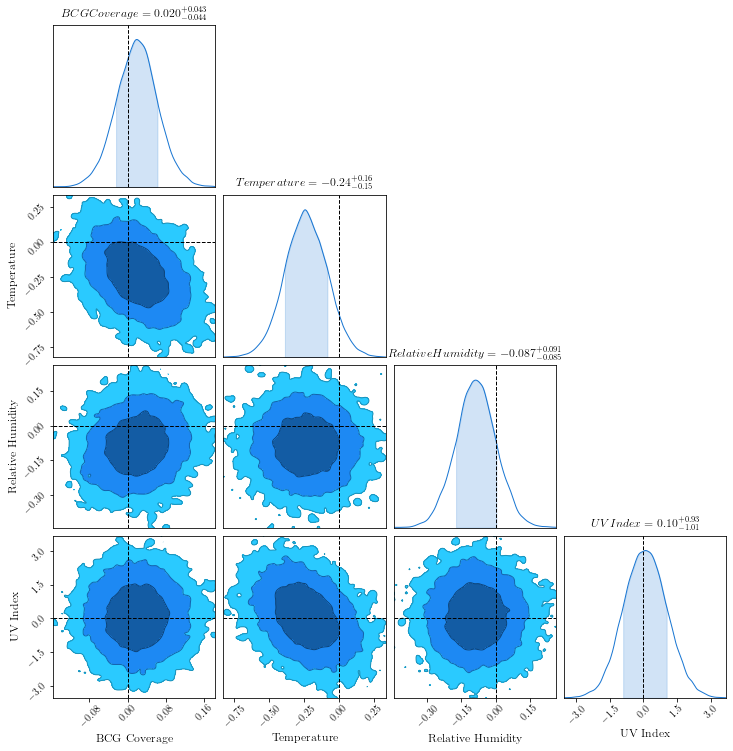

In [71]:
params = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'UV Index']
# params = [r'$\Theta_1$', r'$\Theta_2$', r'$\Theta_3$', r'$\Theta_4$', r'$\Theta_5$']
c = ChainConsumer()
c.add_chain(100*excl_test['W'], parameters=params)
# c.add_chain(100*single_samples[:,:3], parameters=["$x$", "$y$", r"$\beta$"])

c.configure(
# # #             linestyles=["-", "--"], 
            sigmas=[0, 1, 2, 3],
            
# #             legend_kwargs={"loc": "lower left", "fontsize": 20},
# # #             legend_color_text=False, 
# # #             legend_location=(0, 0)
            )

fig = c.plotter.plot(filename='../plots/9_Excl_Test_Corner_3sigma_excl_blood.png', truth=np.zeros(5))
fig.set_size_inches(5 + fig.get_size_inches()) 
# fig.

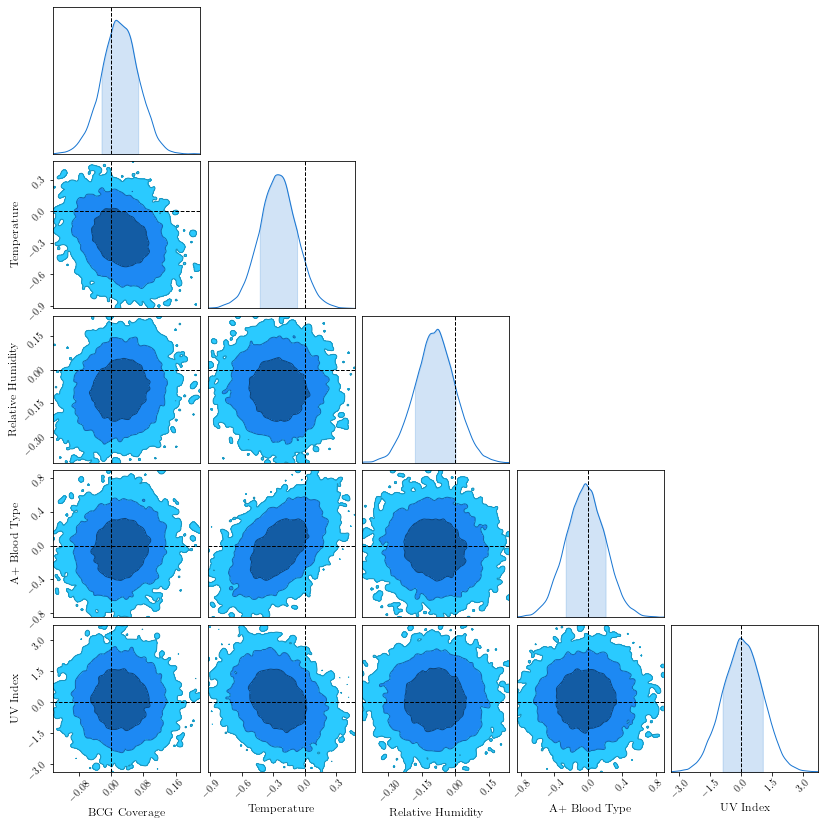

In [29]:
params = ['BCG Coverage', 'Temperature', 'Relative Humidity', 
          'A+ Blood Type', 'UV Index']
# params = [r'$\Theta_1$', r'$\Theta_2$', r'$\Theta_3$', r'$\Theta_4$', r'$\Theta_5$']
c = ChainConsumer()
c.add_chain(100*excl_test['W'], parameters=params)
# c.add_chain(100*single_samples[:,:3], parameters=["$x$", "$y$", r"$\beta$"])

c.configure(
# # #             linestyles=["-", "--"], 
            sigmas=[0, 1, 2, 3],
            
# #             legend_kwargs={"loc": "lower left", "fontsize": 20},
# # #             legend_color_text=False, 
# # #             legend_location=(0, 0)
            )

fig = c.plotter.plot(truth=np.zeros(5))
fig.set_size_inches(5 + fig.get_size_inches()) 
# fig.

In [34]:
with h5py.File('../data/nb_samples/4.1.1.8.4_INCL_BLOOD_MultiVariate_Regression_samples.h5', 'r') as fp:
    all_countries = [c.decode() for c in fp['countries'][()]]

In [35]:
deaths = json.load(open('../data/deaths_dict.json', 'r'))

In [36]:
t0 = json.load(open('../data/T0.json', 'r'))

In [54]:
theta = json.load(open('../data/THETA.json', 'r'))
# theta = json.load(open('TEST.json', 'r'))

In [209]:
theta_df = pd.DataFrame(theta).T
theta_df.columns = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'Tests per 1k', 
                    'Positive Rate', 'A+ Blood Type', 'UV Index']
theta_df['Region'] = theta_df.index

In [218]:
for i in range(len(theta_df)):
    *values, region = theta_df.sort_values('Region').values[i]
    print(f'{region} & {str(round(values[0],1))} & {str(round(values[1],1))} & {str(round(values[2],1))} & {str(round(values[3],1))} & {str(round(values[4],1))} & {str(round(values[5],1))} & {str(round(values[6],1))} \\\ ')

Argentina & 58.5 & 21.6 & 51.0 & 0.8 & 12.7 & 34.3 & 1.3 \\ 
Australia / New South Wales & 38.9 & 19.7 & 74.2 & 17.3 & 3.4 & 31.0 & 1.4 \\ 
Austria & 53.1 & 1.3 & 60.3 & 21.5 & 15.0 & 33.0 & 1.0 \\ 
Canada / Alberta & 0.0 & -3.8 & 74.5 & 15.1 & 7.2 & 36.0 & 0.7 \\ 
Canada / British Columbia & 0.0 & 7.9 & 70.9 & 15.1 & 4.4 & 36.0 & 0.8 \\ 
Canada / Ontario & 0.0 & -2.9 & 72.5 & 15.1 & 10.5 & 36.0 & 0.8 \\ 
Canada / Quebec & 0.0 & -10.8 & 68.8 & 14.8 & 27.3 & 36.0 & 0.7 \\ 
Chile & 93.1 & 15.8 & 62.8 & 6.6 & 13.7 & 8.7 & 1.5 \\ 
Colombia & 86.4 & 14.2 & 90.5 & 1.2 & 12.9 & 26.1 & 2.4 \\ 
Cuba & 46.9 & 22.3 & 79.3 & 2.6 & 7.8 & 32.8 & 2.5 \\ 
Czechia & 73.5 & 3.0 & 56.7 & 16.8 & 6.7 & 36.0 & 1.0 \\ 
Denmark & 50.7 & 4.8 & 61.6 & 17.3 & 16.1 & 37.0 & 0.7 \\ 
Estonia & 27.2 & 1.9 & 65.1 & 32.5 & 5.1 & 30.8 & 0.6 \\ 
Finland & 80.4 & 0.2 & 68.1 & 11.0 & 10.4 & 38.0 & 0.4 \\ 
France & 71.4 & 8.6 & 71.6 & 1.5 & 53.3 & 37.0 & 0.7 \\ 
Germany & 49.7 & 0.8 & 48.0 & 13.8 & 12.0 & 37.0 & 0.8 \\ 
Gr

In [55]:
theta

{'Switzerland': [31.93460244829413,
  -1.0293055772781372,
  80.31806182861328,
  20.586999893188477,
  18.056520462036133,
  37.0,
  0.7805555462837219],
 'France': [71.40541749065814,
  8.592340469360352,
  71.57737731933594,
  1.5163333415985107,
  53.29663848876953,
  37.0,
  0.694444477558136],
 'Canada / Ontario': [0.0,
  -2.9012367725372314,
  72.54961395263672,
  15.050000190734863,
  10.54592514038086,
  36.0,
  0.7910052537918091],
 'Canada / British Columbia': [0.0,
  7.873392581939697,
  70.90216827392578,
  15.050000190734863,
  4.356861114501953,
  36.0,
  0.8429951667785645],
 'Argentina': [58.472680213281556,
  21.576786041259766,
  51.022132873535156,
  0.8040000200271606,
  12.66489315032959,
  34.26,
  1.3470051288604736],
 'Turkey': [92.82607931634648,
  5.907082557678223,
  57.91666793823242,
  3.2960000038146973,
  40.28778076171875,
  37.8,
  1.2083334922790527],
 'Philippines': [61.77373232382383,
  27.45600128173828,
  82.47859191894531,
  0.48100000619888306,


In [38]:
def sigmoid(a, t0, t):
    
    return 1.0/(1.0+np.exp(-a*(t-t0)))

def step_inter(Di, GR1, GR2, a, t0, MAX_DAYS):
    
    if Di.ndim>0:
        Di = Di[:,None]
        GR1 = GR1[:,None]
        GR2 = GR2[:,None]
        a = a[:,None]
        t0 = t0[:,None]
    t = np.arange(1, MAX_DAYS)[None,:]
    step = sigmoid(a, t0, t)
    logGR = np.log(np.concatenate([Di, (GR1 + (GR2-GR1)*step)], axis=1))
    D = np.exp(np.cumsum(logGR, axis=1))
    
    return D

In [39]:
curved_samples = read_samples('../data/nb_samples/4.1.1.10.2_Sigmoid_Growth_Regression_samples.h5')

In [40]:
curved = {}
for i, c in enumerate(curved_samples['countries']):
    curved[c.decode()] = np.stack([curved_samples['Di_ind'][:,i],
                                   curved_samples['GR1_ind'][:,i], 
                                   curved_samples['GR2_ind'][:,i], 
                                   curved_samples['tr_ind'][:,i], 
                                   curved_samples['t0_ind'][:,i]], axis=1)

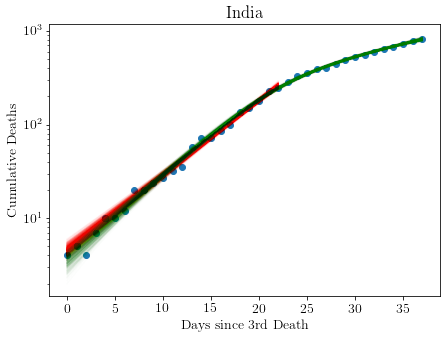

In [45]:
# plt.rcParams['font.size'] = 10
fig, a = plt.subplots(1, 1, figsize=(7, 5))
i = 31
c = all_countries[i]
t = np.arange(len(deaths[c]))[:t0[c]]
a.set_title(c)
a.semilogy(deaths[c], 'o')
a.semilogy((none['Di_ind'][::10,i:i+1]*none['GR_ind'][::10,i:i+1]**t[None,:]).T, 'r', alpha=0.01)
a.semilogy(step_inter(*curved[c].T, len(deaths[c]))[::10,:].T, 'g', alpha=0.01)
a.set_xlabel('Days since 3rd Death')
a.set_ylabel('Cumulative Deaths')

plt.subplots_adjust(hspace=0.3)    
plt.savefig('../plots/9_ExampleFit_India.png', dpi=300)     
# plt.rcParams['font.size'] = 14

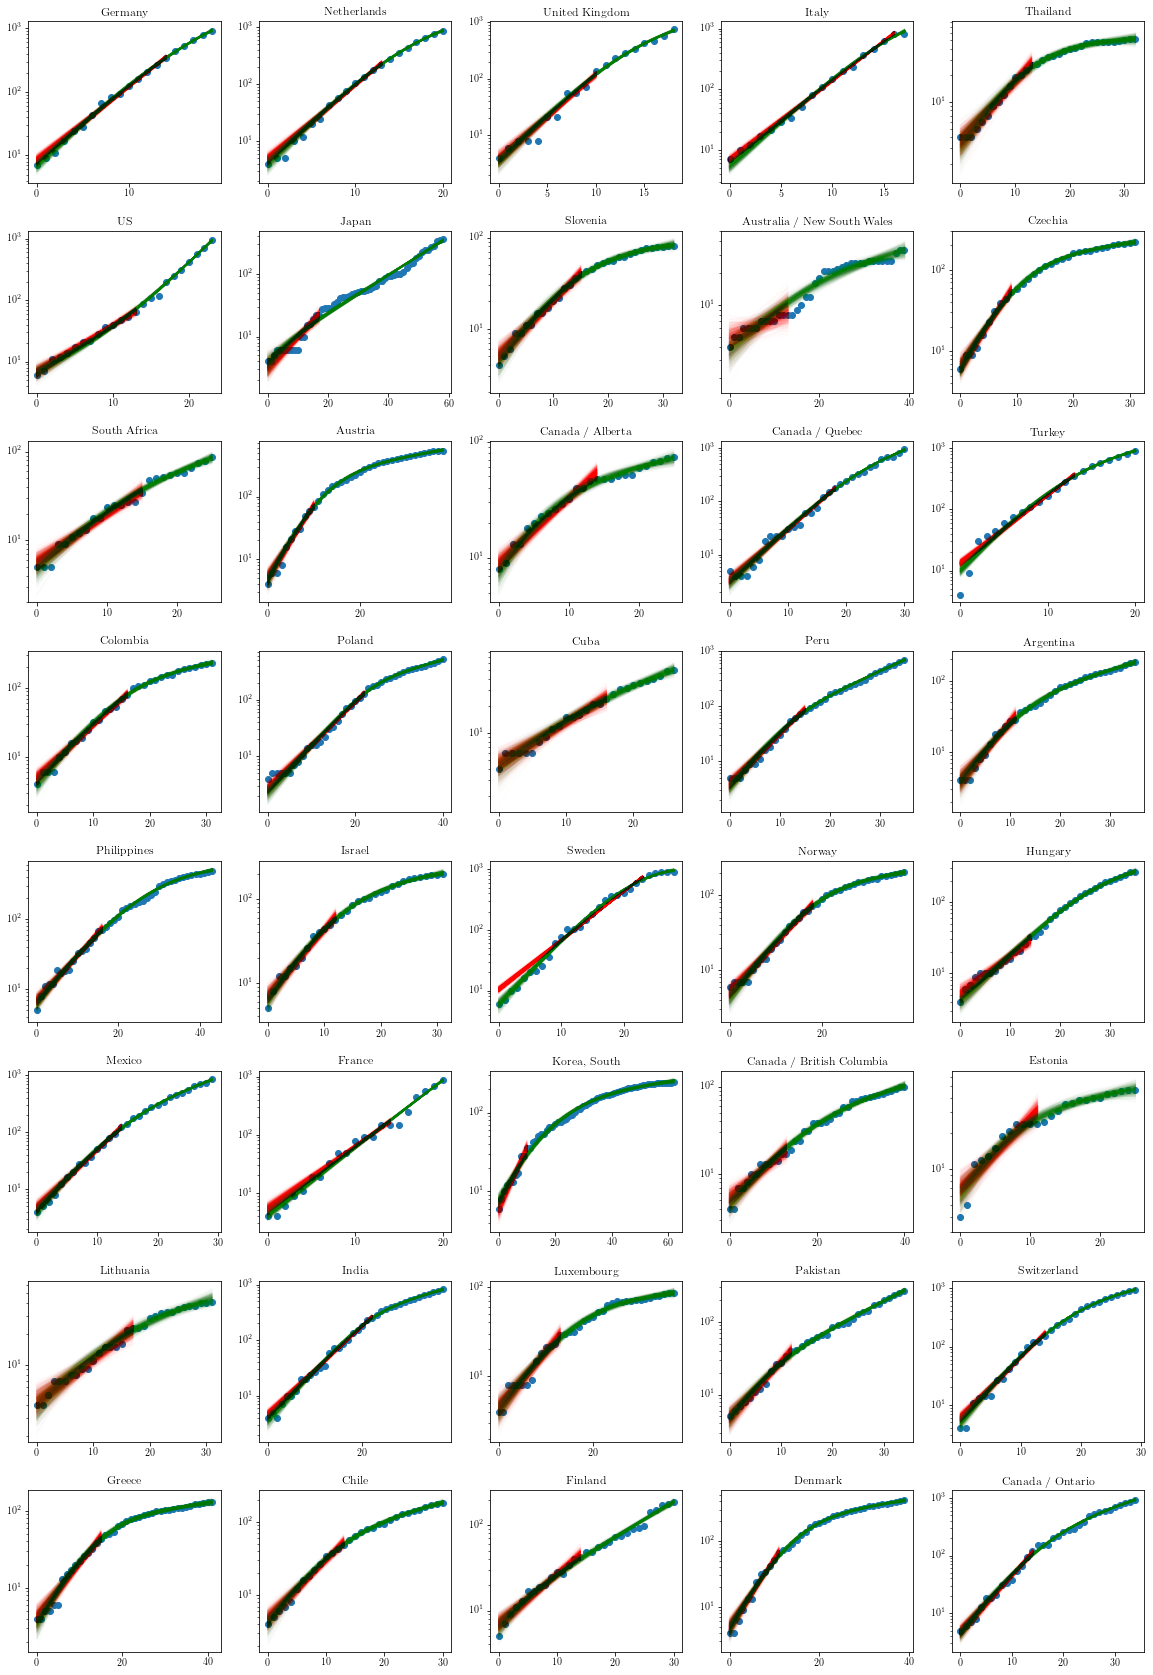

In [30]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(8, 5, figsize=(20, 30))
a = ax.flatten()
for i, c in enumerate(all_countries):
    t = np.arange(len(deaths[c]))[:t0[c]]
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy((none['Di_ind'][::10,i:i+1]*none['GR_ind'][::10,i:i+1]**t[None,:]).T, 'r', alpha=0.01)
    a[i].semilogy(step_inter(*curved[c].T, len(deaths[c]))[::10,:].T, 'g', alpha=0.01)

plt.subplots_adjust(hspace=0.3)    
plt.savefig('../plots/9_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

In [39]:
p = np.linspace(0, 65, 1000)

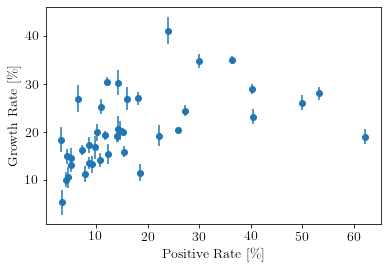

In [49]:
for i, c in enumerate(all_countries):
    plt.errorbar(theta[c][4], 100*(np.mean(none['GR_ind'][:,i])-1), 
                 yerr=100*np.std(none['GR_ind'][:,i]), 
                 marker='o', color='tab:blue', ) 
    
# plt.plot(p, 100*((pos['GR_grp_mean']-1)+p[None,:]*pos['alpha'])[::10,:].T, alpha=0.01, color='tab:red')

plt.ylabel('Growth Rate [\%]')
plt.xlabel('Positive Rate [\%]')
plt.savefig('../plots/9_PosRate.png', dpi=200)

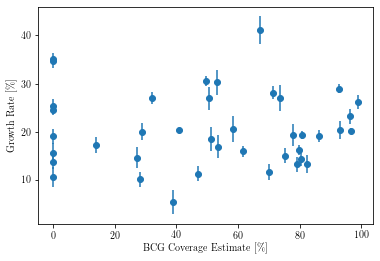

In [33]:
for i, c in enumerate(all_countries):
    plt.errorbar(theta[c][0], 100*(np.mean(none['GR_ind'][:,i])-1), 
                 yerr=100*np.std(none['GR_ind'][:,i]), 
                 marker='o', color='tab:blue', ) 
    
# plt.plot(p, 100*((pos['GR_grp_mean']-1)+p[None,:]*pos['alpha'])[::10,:].T, alpha=0.01, color='tab:red')

plt.ylabel('Growth Rate [\%]')
plt.xlabel('BCG Coverage Estimate [\%]')
plt.savefig('../plots/9_BCG_GR.png', dpi=200)

In [56]:
print('Country/Region & BCG Coverage (\%) & Temperature ($^\circ$C) & Relative Humidity (\%) & Tests per 1k & Positive Rate (\%) & A+ Blood Type Coverage (\%) & UV Index')
for c in all_countries:
    fac = theta[c]
    print(f'{c} & {str(round(fac[0], 1))} & {str(round(fac[1], 1))} & {str(round(fac[2], 1))} & {str(round(fac[3], 1))} & {str(round(fac[4], 1))} & {str(round(fac[5], 1))} & {str(round(fac[6], 1))} \\\ ')

Country/Region & BCG Coverage (\%) & Temperature ($^\circ$C) & Relative Humidity (\%) & Tests per 1k & Positive Rate (\%) & A+ Blood Type Coverage (\%) & UV Index
Germany & 49.7 & 0.8 & 48.0 & 13.8 & 12.0 & 37.0 & 0.8 \\ 
Netherlands & 0.0 & 4.5 & 44.9 & 4.0 & 29.9 & 35.0 & 0.8 \\ 
United Kingdom & 67.2 & 3.5 & 71.3 & 1.6 & 19.6 & 35.0 & 0.5 \\ 
Italy & 0.0 & 4.5 & 46.5 & 1.2 & 40.0 & 36.0 & 1.2 \\ 
Thailand & 53.4 & 31.1 & 60.8 & 0.6 & 10.0 & 16.9 & 2.4 \\ 
US & 0.0 & 11.8 & 85.0 & 0.9 & 61.0 & 35.7 & 1.2 \\ 
Japan & 70.0 & 4.4 & 64.8 & 1.4 & 16.8 & 39.8 & 1.2 \\ 
Slovenia & 75.2 & 6.3 & 47.1 & 20.6 & 4.4 & 33.0 & 1.1 \\ 
Australia / New South Wales & 38.9 & 19.7 & 74.2 & 17.3 & 3.4 & 31.0 & 1.4 \\ 
Czechia & 73.5 & 3.0 & 56.7 & 16.8 & 6.7 & 36.0 & 1.0 \\ 
South Africa & 79.2 & 21.2 & 43.3 & 2.2 & 4.5 & 32.0 & 1.9 \\ 
Austria & 53.1 & 1.3 & 60.3 & 21.5 & 15.0 & 33.0 & 1.0 \\ 
Canada / Alberta & 0.0 & -3.8 & 74.5 & 15.1 & 7.2 & 36.0 & 0.7 \\ 
Canada / Quebec & 0.0 & -10.8 & 68.8 & 14.8

In [47]:
theta[all_countries[0]]

[49.73418322875438,
 0.7879164814949036,
 48.0,
 13.765142440795898,
 12.036505699157715,
 37.0]

# BCG Data Table

In [12]:
with open('BCG_Coverage_Estimate_Sources.json', 'r') as fp:
    bcg_src = json.load(fp)
with open('BCG_Coverage_Estimates.json', 'r') as fp:
    bcg_cov = json.load(fp)

In [20]:
for c in all_countries:
    print(f'{c} & {str(round(bcg_cov[c],1))} \% & {bcg_src[c]} \\\ ')

Germany & 49.7 \% & BCG ATLAS \\ 
Netherlands & 0.0 \% & BCG ATLAS \\ 
United Kingdom & 67.2 \% & BCG ATLAS \\ 
Italy & 0.0 \% & BCG ATLAS \\ 
Thailand & 53.4 \% & BCG ATLAS \\ 
US & 0.0 \% & BCG ATLAS \\ 
Japan & 70.0 \% & BCG ATLAS \\ 
Slovenia & 75.2 \% & BCG ATLAS \\ 
Australia / New South Wales & 38.9 \% & BCG ATLAS \\ 
Czechia & 73.5 \% & BCG ATLAS \\ 
South Africa & 79.2 \% & BCG ATLAS \\ 
Austria & 53.1 \% & BCG ATLAS \\ 
Canada / Alberta & 0.0 \% & BCG ATLAS \\ 
Canada / Quebec & 0.0 \% & BCG ATLAS \\ 
Turkey & 92.8 \% & BCG ATLAS \\ 
Colombia & 86.4 \% & BCG ATLAS \\ 
Poland & 80.8 \% & BCG ATLAS \\ 
Cuba & 46.9 \% & WHO \\ 
Peru & 96.5 \% & BCG ATLAS \\ 
Argentina & 58.5 \% & WHO \\ 
Philippines & 61.8 \% & WHO \\ 
Israel & 29.0 \% & BCG ATLAS \\ 
Sweden & 40.9 \% & BCG ATLAS \\ 
Norway & 79.8 \% & BCG ATLAS \\ 
Hungary & 82.3 \% & BCG ATLAS \\ 
Mexico & 98.9 \% & BCG ATLAS \\ 
France & 71.4 \% & BCG ATLAS \\ 
Korea, South & 51.3 \% & BCG ATLAS \\ 
Canada / British Columbia 

In [13]:
bcg_src

{'Burundi': 'WHO',
 'Comoros': 'WHO',
 'Djibouti': 'WHO',
 'Eritrea': 'WHO',
 'Kenya': 'WHO',
 'Madagascar': 'WHO',
 'Malawi': 'WHO',
 'Mauritius': 'WHO',
 'Mozambique': 'WHO',
 'Seychelles': 'WHO',
 'Somalia': 'WHO',
 'Zambia': 'WHO',
 'Zimbabwe': 'WHO',
 'Cameroon': 'WHO',
 'Central African Republic': 'WHO',
 'Chad': 'WHO',
 'Equatorial Guinea': 'WHO',
 'Gabon': 'WHO',
 'Sao Tome and Principe': 'WHO',
 'Botswana': 'WHO',
 'Lesotho': 'WHO',
 'Namibia': 'WHO',
 'Benin': 'WHO',
 'Burkina Faso': 'WHO',
 'Ghana': 'WHO',
 'Guinea': 'WHO',
 'Guinea-Bissau': 'WHO',
 'Liberia': 'WHO',
 'Mali': 'WHO',
 'Mauritania': 'WHO',
 'Niger': 'WHO',
 'Togo': 'WHO',
 'Algeria': 'WHO',
 'Egypt': 'WHO',
 'Libya': 'WHO',
 'Morocco': 'WHO',
 'Tunisia': 'WHO',
 'Azerbaijan': 'WHO',
 'Georgia': 'WHO',
 'Iraq': 'WHO',
 'Jordan': 'WHO',
 'Kuwait': 'WHO',
 'Oman': 'WHO',
 'Qatar': 'WHO',
 'United Arab Emirates': 'WHO',
 'Kazakhstan': 'WHO',
 'Tajikistan': 'WHO',
 'Turkmenistan': 'WHO',
 'Afghanistan': 'WHO',
 'Ma

# Factor Graph Images

In [164]:
x = np.linspace(-4, 4, 10001)
y = np.exp(-x**2/2)/np.sqrt(2.*np.pi)

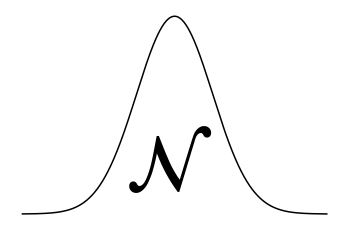

In [177]:
fig, ax = plt.subplots(1,1)
ax.plot(x, y, 'k')
ax.text(-1.3, 0.05, r'$\mathcal{N}$', fontsize=80)
ax.set_axis_off()
plt.savefig('../plots/9_Normal2.svg')

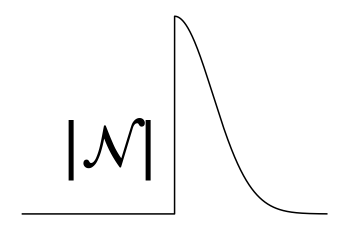

In [187]:
fig, ax = plt.subplots(1,1)
y1 = y.copy()
y1[x<0] = 0
ax.plot(x, y1, 'k')
ax.text(-3, 0.1, r'|$ \mathcal{N} |$', fontsize=60)
ax.set_axis_off()
plt.savefig('../plots/9_HalfNormal2.svg')

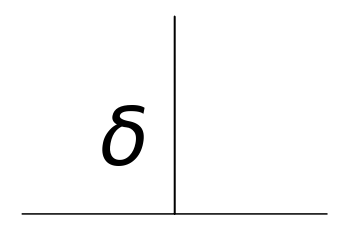

In [182]:
fig, ax = plt.subplots(1,1)
y2 = y.copy()
y2[np.abs(x)>0] = 0
ax.plot(x, y2, 'k')
ax.text(-2, 0.1, r'$\delta$', fontsize=80)
ax.set_axis_off()
plt.savefig('../plots/9_Delta2.svg')

In [188]:
from scipy.stats import poisson

In [196]:
from scipy.special import factorial

In [197]:
def poisson(x, lam):
    return lam**x*np.exp(-lam)/factorial(x)

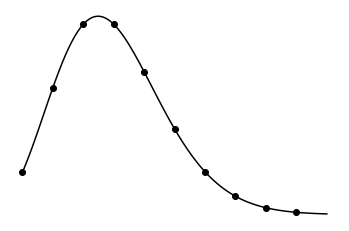

In [201]:
fig, ax = plt.subplots(1,1)
xx = np.linspace(0, 10, 100)
ax.plot(xx, poisson(xx, 3), 'k')
ax.plot(np.arange(10), poisson(np.arange(10), 3), 'ko')
ax.set_axis_off()
plt.savefig('../plots/9_Poisson.svg')